In [1]:
# netcdf/numpy/xray/stats
import xarray as xr

from sublimpy import variables
from sublimpy import utils
from sublimpy import tidy

import pandas as pd
import datetime as dt
import pytz

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('svg')

RendererRegistry.enable('svg')

# Inputs

In [2]:
sos_download_dir='/data2/elilouis/sublimationofsnow/sosnoqc'
DATE_FORMAT_STR = '%Y%m%d'
# start_date = '20221201'
# end_date = dt.datetime.strftime(dt.date.today() - dt.timedelta(days=1), DATE_FORMAT_STR)
start_date = '20221130'
end_date = '20230510'
PLANAR_FIT = False




datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()

VARIABLE_NAMES = [
    # Sonic Anemometer Data for 4 towers
    'tc_1m_uw',     'spd_1m_uw',     'dir_1m_uw',     'u_1m_uw',   'v_1m_uw',   'w_1m_uw',   'u_u__1m_uw',    'v_v__1m_uw',    'w_w__1m_uw',    
        'u_w__1m_uw',    'v_w__1m_uw',  'u_tc__1m_uw',  'v_tc__1m_uw',   'u_h2o__1m_uw',  'v_h2o__1m_uw',   'w_tc__1m_uw',   'w_h2o__1m_uw',
    'tc_3m_uw',     'spd_3m_uw',     'dir_3m_uw',     'u_3m_uw',   'v_3m_uw',   'w_3m_uw',   'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    
        'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_h2o__3m_uw',  'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_h2o__3m_uw',
    'tc_10m_uw',    'spd_10m_uw',    'dir_10m_uw',    'u_10m_uw',  'v_10m_uw',  'w_10m_uw',  'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   
        'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_h2o__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_h2o__10m_uw',

    'tc_1m_ue',     'spd_1m_ue',     'dir_1m_ue',     'u_1m_ue',   'v_1m_ue',   'w_1m_ue',   'u_u__1m_ue',    'v_v__1m_ue',    'w_w__1m_ue',    
        'u_w__1m_ue',    'v_w__1m_ue',  'u_tc__1m_ue',  'v_tc__1m_ue',   'u_h2o__1m_ue',  'v_h2o__1m_ue',   'w_tc__1m_ue',   'w_h2o__1m_ue',
    'tc_3m_ue',     'spd_3m_ue',     'dir_3m_ue',     'u_3m_ue',   'v_3m_ue',   'w_3m_ue',   'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    
        'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_h2o__3m_ue',  'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_h2o__3m_ue',
    'tc_10m_ue',    'spd_10m_ue',    'dir_10m_ue',    'u_10m_ue',  'v_10m_ue',  'w_10m_ue',  'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   
        'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_h2o__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_h2o__10m_ue',

    'tc_1m_d',      'spd_1m_d',     'dir_1m_d',     'u_1m_d',   'v_1m_d',   'w_1m_d',   'u_u__1m_d',    'v_v__1m_d',    'w_w__1m_d',    
        'u_w__1m_d',    'v_w__1m_d',  'u_tc__1m_d',  'v_tc__1m_d',   'u_h2o__1m_d',  'v_h2o__1m_d',   'w_tc__1m_d',   'w_h2o__1m_d',
    'tc_3m_d',      'spd_3m_d',     'dir_3m_d',     'u_3m_d',   'v_3m_d',   'w_3m_d',   'u_u__3m_d',    'v_v__3m_d',    'w_w__3m_d',    
        'u_w__3m_d',    'v_w__3m_d',  'u_tc__3m_d',  'v_tc__3m_d',   'u_h2o__3m_d',  'v_h2o__3m_d',   'w_tc__3m_d',   'w_h2o__3m_d',
    'tc_10m_d',     'spd_10m_d',    'dir_10m_d',    'u_10m_d',  'v_10m_d',  'w_10m_d',  'u_u__10m_d',   'v_v__10m_d',   'w_w__10m_d',   
        'u_w__10m_d',   'v_w__10m_d', 'u_tc__10m_d', 'v_tc__10m_d',  'u_h2o__10m_d', 'v_h2o__10m_d',  'w_tc__10m_d',  'w_h2o__10m_d',

    'tc_2m_c',  'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',   'w_2m_c',   'u_u__2m_c',    'v_v__2m_c',    'w_w__2m_c',    
        'u_w__2m_c',    'v_w__2m_c',  'u_tc__2m_c',  'v_tc__2m_c',   'u_h2o__2m_c',  'v_h2o__2m_c',   'w_tc__2m_c',   'w_h2o__2m_c',
    'tc_3m_c',  'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',   'w_3m_c',   'u_u__3m_c',    'v_v__3m_c',    'w_w__3m_c',    
        'u_w__3m_c',    'v_w__3m_c',  'u_tc__3m_c',  'v_tc__3m_c',   'u_h2o__3m_c',  'v_h2o__3m_c',   'w_tc__3m_c',   'w_h2o__3m_c',
    'tc_5m_c',  'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',   'w_5m_c',   'u_u__5m_c',    'v_v__5m_c',    'w_w__5m_c',    
        'u_w__5m_c',    'v_w__5m_c',  'u_tc__5m_c',  'v_tc__5m_c',   'u_h2o__5m_c',  'v_h2o__5m_c',   'w_tc__5m_c',   'w_h2o__5m_c',
    'tc_10m_c', 'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',  'w_10m_c',  'u_u__10m_c',   'v_v__10m_c',   'w_w__10m_c',   
        'u_w__10m_c',   'v_w__10m_c', 'u_tc__10m_c', 'v_tc__10m_c',  'u_h2o__10m_c', 'v_h2o__10m_c',  'w_tc__10m_c',  'w_h2o__10m_c',
    'tc_15m_c', 'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',  'w_15m_c',  'u_u__15m_c',   'v_v__15m_c',   'w_w__15m_c',   
        'u_w__15m_c',   'v_w__15m_c', 'u_tc__15m_c', 'v_tc__15m_c',  'u_h2o__15m_c', 'v_h2o__15m_c',  'w_tc__15m_c',  'w_h2o__15m_c',
    'tc_20m_c', 'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',  'w_20m_c',  'u_u__20m_c',   'v_v__20m_c',   'w_w__20m_c',   
        'u_w__20m_c',   'v_w__20m_c', 'u_tc__20m_c', 'v_tc__20m_c',  'u_h2o__20m_c', 'v_h2o__20m_c',  'w_tc__20m_c',  'w_h2o__20m_c',

    
    # Temperature & Relative Humidity Array 
    'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    # Pressure Sensors
    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    # Blowing snow/FlowCapt Sensors
    'SF_avg_1m_ue', 'SF_avg_2m_ue',

    # Apogee sensors
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

    # Snow-level temperature arrays (towers D and UW)
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
    'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
    
    # Downward Facing Longwave Radiometer (tower D) - for measuring snow surface temperature
    'Rpile_out_9m_d',
    'Tcase_out_9m_d',
    
    # Upward Facing Longwave Radiometer (tower D)
    'Rpile_in_9m_d',
    'Tcase_in_9m_d',
    
    # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
    'Rsw_in_9m_d',
    'Rsw_out_9m_d',

    # Snow Pillow SWE
    'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

    # Soil Moisture
    'Qsoil_d',
]

# Download and Clean SoS data

In [3]:
sos_ds = utils.download_sos_data(start_date, end_date, VARIABLE_NAMES, sos_download_dir, cache=True, planar_fit=False)

Caching...skipping download for 20221130
Caching...skipping download for 20221201
Caching...skipping download for 20221202
Caching...skipping download for 20221203
Caching...skipping download for 20221204
Caching...skipping download for 20221205
Caching...skipping download for 20221206
Caching...skipping download for 20221207
Caching...skipping download for 20221208
Caching...skipping download for 20221209
Caching...skipping download for 20221210
Caching...skipping download for 20221211
Caching...skipping download for 20221212
Caching...skipping download for 20221213
Caching...skipping download for 20221214
Caching...skipping download for 20221215
Caching...skipping download for 20221216


KeyboardInterrupt: 

In [4]:
example = xr.open_dataset(os.path.join(sos_download_dir, "isfs_20221030.nc"))

In [22]:
[var for var in example if 'rad' in var], [var for var in example if var.startswith('Rsw')], [var for var in example if 'Rpile' in var]

(['Vmote_rad_9m_d'],
 ['Rsw_in_uw', 'Rsw_out_uw', 'Rsw_in_9m_d', 'Rsw_out_9m_d'],
 ['Rpile_in_uw', 'Rpile_out_uw', 'Rpile_in_9m_d', 'Rpile_out_9m_d'])

In [24]:
example['Rpile_out_uw']

<xarray.DataArray 'Rpile_out_uw' (time: 288)>
[288 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2022-10-30T00:02:30 ... 2022-10-30T23:57:30
Attributes:
    long_name:   Outgoing Thermopile, Hukesflux NR01
    short_name:  Rpile.out.uw
    units:       W/m^2

# Add Variables

In [4]:
sos_ds = variables.add_longwave_radiation(sos_ds)
sos_ds = variables.add_surface_temps(sos_ds)
sos_ds = variables.add_potential_virtual_temperatures(sos_ds)
sos_ds = variables.add_surface_potential_virtual_temperatures(sos_ds)
sos_ds = variables.add_tke(sos_ds)
sos_ds = variables.add_gradients_and_ri(sos_ds)
sos_ds = variables.add_obukhov_length(sos_ds)

/home/elilouis/mambaforge/envs/arm/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/elilouis/mambaforge/envs/arm/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


(-10.0, 10.0)

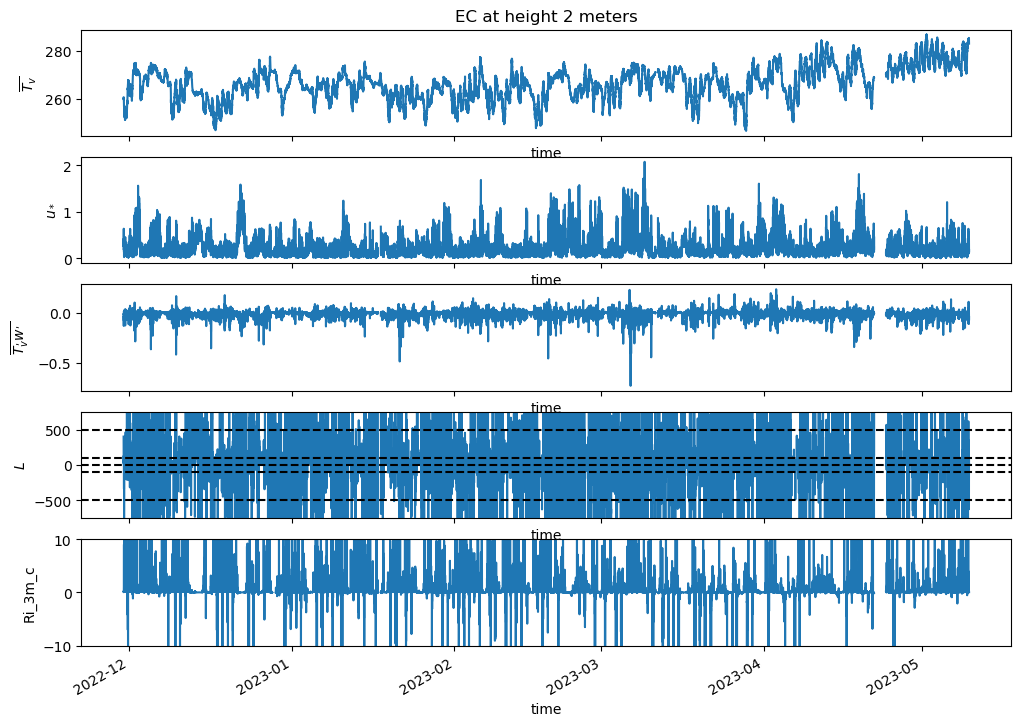

In [5]:
i = 2
fig, axes = plt.subplots(5, 1, figsize=(12,8), sharex=True)

(sos_ds[f'Tpotvirtual_{i}m_c']+273.15)

(sos_ds[f'Tvirtual_{i}m_c'] + 273.15).plot(ax = axes[0])
axes[0].set_ylabel(r'$\overline{T_v}$')

sos_ds[f'u*_{i}m_c'].plot(ax = axes[1])
axes[1].set_ylabel(r'$u_*$')

sos_ds[f'w_tc__{i}m_c'].plot(ax = axes[2])
axes[2].set_ylabel(r'$\overline{T_v^, w^,}$')

sos_ds[f'L_{i}m_c'].plot(ax = axes[3])
axes[3].axhline(-500, color='k', linestyle='--')
axes[3].axhline(-100, color='k', linestyle='--')
axes[3].axhline(0, color='k', linestyle='--')
axes[3].axhline(100, color='k', linestyle='--')
axes[3].axhline(500, color='k', linestyle='--')
axes[3].set_ylim(-750,750)
axes[3].set_ylabel(r'$L$')

axes[0].set_title(f"EC at height {i} meters")

sos_ds[f'Ri_3m_c'].plot(ax = axes[4])
axes[4].set_ylim(-10,10)

# Get Tidy Dataset

In [6]:
tidy_df = tidy.get_tidy_dataset(sos_ds, list(sos_ds.data_vars))

In [7]:
tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, pytz.timezone('US/Mountain'))

Which variables did not get a "measurement" name assigned?

In [8]:
variables_with_no_measurement = tidy_df[tidy_df.measurement.apply(lambda x: x is None)].variable.unique()
variables_with_no_measurement

array(['Tcase_in_9m_d', 'Tcase_out_9m_d', 'Rpile_out_9m_d',
       'Rpile_in_9m_d'], dtype=object)

# Calculate 30 Minute averages

In [9]:
tidy_df_30Min = pd.DataFrame(
    tidy_df.set_index('time').groupby(
        ['measurement', 'variable', 'height',  'tower']
    )['value'].resample('30Min').mean()
).reset_index()

# Save dataset

In [ ]:
if PLANAR_FIT:
    tidy_df_30Min.to_parquet(f'tidy_df_30Min_{start_date}_{end_date}_planar_fit.parquet', index=False)
    tidy_df.to_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit.parquet', index=False)
else:
    tidy_df_30Min.to_parquet(f'tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet', index=False)
    tidy_df.to_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet', index=False)

# Create disdrometer dataset with a "days since precip" variable

## Load disdrometer data

In [4]:
import act

In [5]:
files = act.discovery.download_data(
    os.getenv("ARM_USERNAME"),
    os.getenv("ARM_TOKEN"),
    'gucldM1.b1',
    start_date,
    end_date,
    output='/data2/elilouis/sublimationofsnow/gucldM1.b1'
)

[DOWNLOADING] gucldM1.b1.20221201.000000.cdf
[DOWNLOADING] gucldM1.b1.20230211.000000.cdf
[DOWNLOADING] gucldM1.b1.20230416.000000.cdf
[DOWNLOADING] gucldM1.b1.20221209.000000.cdf
[DOWNLOADING] gucldM1.b1.20221210.000000.cdf
[DOWNLOADING] gucldM1.b1.20221211.000000.cdf
[DOWNLOADING] gucldM1.b1.20230212.000000.cdf
[DOWNLOADING] gucldM1.b1.20230417.000000.cdf
[DOWNLOADING] gucldM1.b1.20221203.000000.cdf
[DOWNLOADING] gucldM1.b1.20221204.000000.cdf
[DOWNLOADING] gucldM1.b1.20221202.000000.cdf
[DOWNLOADING] gucldM1.b1.20230415.000000.cdf
[DOWNLOADING] gucldM1.b1.20221206.000000.cdf
[DOWNLOADING] gucldM1.b1.20221205.000000.cdf
[DOWNLOADING] gucldM1.b1.20221207.000000.cdf
[DOWNLOADING] gucldM1.b1.20221208.000000.cdf
[DOWNLOADING] gucldM1.b1.20230418.000000.cdf
[DOWNLOADING] gucldM1.b1.20230419.000000.cdf
[DOWNLOADING] gucldM1.b1.20230213.000000.cdf
[DOWNLOADING] gucldM1.b1.20221212.000000.cdf
[DOWNLOADING] gucldM1.b1.20230420.000000.cdf
[DOWNLOADING] gucldM1.b1.20230421.000000.cdf
[DOWNLOADI

In [6]:
disdro_ds = xr.open_mfdataset(files)

In [18]:
disdro_df = disdro_ds.to_dataframe().reset_index()

In [23]:
disdro_df = utils.modify_df_timezone(disdro_df, pytz.UTC, pytz.timezone('US/Mountain'))
disdro_df = disdro_df.set_index('time').loc[slice(start_date, end_date)]

## Calculate "days since precip"

In [8]:
disdro_daily_max_precip_date_df = disdro_df.set_index(
    "time"
)[['precip_rate']].resample(
    "1440Min"
).max().reset_index()

disdro_daily_mean_precip_date_df = disdro_df.set_index(
    "time"
)[['precip_rate']].resample(
    "1440Min"
).max().reset_index()

s = disdro_daily_max_precip_date_df.groupby(disdro_daily_max_precip_date_df['precip_rate'].ne(0).cumsum())['time'].transform('first')
disdro_daily_max_precip_date_df['days_since_precip'] = (disdro_daily_max_precip_date_df['time'] - s).dt.days

In [9]:
daily_mean_precip_df = disdro_df.groupby("time")['precip_rate'].max()

daily_mean_precip_df = pd.DataFrame(daily_mean_precip_df.resample("1440Min").mean()*24/10) # resample to one day in cm/hr SWE

In [10]:
disdro_daily_max_precip_date_df['daily_precip (cm)'] =  daily_mean_precip_df['precip_rate'].values

## Cache Downloaded Disdrometer data

In [14]:
disdro_daily_max_precip_date_df.to_csv("disdro_daily_max_precip_date_df.csv")